In [7]:
import numpy as np

import torch
import pickle as pkl
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
use_cuda = False#torch.cuda.is_available()
# device = torch.device('cuda:6') if use_cuda else torch.device('cpu')

In [2]:
s_group_data = 3
with open(f'./data/diffusion_process_1d_discrite_macro_s_group={s_group_data}.pkl','rb') as f:
# with open(f'./data/diffusion_process_1d_discrite.pkl','rb') as f:
    data = pkl.load(f)[:,:20,:]
data = torch.tensor(data,dtype=torch.float)
data.shape

torch.Size([50, 20, 100])

In [3]:

L = data.shape[-1]
pred_step = 1
data_x = data[:,:-pred_step,:].reshape(-1,L)
data_y = data[:,pred_step:,:].reshape(-1,L)
data_x.shape


torch.Size([950, 100])

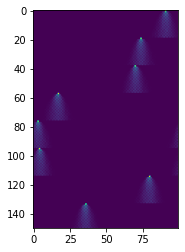

In [4]:
plt.imshow(data_x[:150,:])

In [5]:
batch_size = 64
valid_ratio = 0.2
test_ratio = 0.2
cut1 = int((valid_ratio+test_ratio)*data_x.shape[0])
cut2 =  int(test_ratio*data_x.shape[0])
print(cut1,cut2)
train_data_x = data_x[:cut1,:]
train_data_y = data_y[:cut1,:]
valid_data_x = data_x[cut1:cut1+cut2,:]
valid_data_y = data_y[cut1:cut1+cut2,:]

print(train_data_x.shape,valid_data_x.shape)
# print(dataset1)
dataset1 = torch.utils.data.dataset.TensorDataset(train_data_x, train_data_y)
dataset2 = torch.utils.data.dataset.TensorDataset(valid_data_x, valid_data_y)

train_loader = torch.utils.data.DataLoader(dataset=dataset1,
                                           batch_size=batch_size, 
                                           shuffle=False)

valid_loader = torch.utils.data.DataLoader(dataset=dataset2,
                                           batch_size=batch_size, 
                                           shuffle=True)


380 190
torch.Size([380, 100]) torch.Size([190, 100])


In [6]:
kernel_size=7
import torch.nn.functional as F

class NormalizedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,padding,padding_mode):
        super(NormalizedConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding, padding_mode, bias=False)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        # 对权重进行归一化
        normed_weight = self.softmax(self.conv.weight)
        return F.conv1d(x, normed_weight, self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation)

class Diffusion1D(nn.Module):
    def __init__(self,channel=1):
        super(Diffusion1D, self).__init__()
        kernel = kernel_size
        self.normconv = NormalizedConv1d(1, channel, kernel, padding=1, padding_mode='same')
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.normconv(x.unsqueeze(1))
        x = torch.transpose(x,2,1).squeeze()
        return x

In [9]:

kl_loss = nn.KLDivLoss()
loss_F2 = torch.nn.MSELoss()
L = data.shape[-1]
seed = 2050
num_epochs = 4000
hidden_size = 8
torch.manual_seed(seed)
random.seed(seed)
model = Diffusion1D()
model = model.cuda() if use_cuda else model
optimizer2 = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
last_valid_loss = 10000
count = 0
train_losses2 = []
valid_losses2 = []
for epoch in tqdm(range(num_epochs)):
    loss_t2 = []
    loss_v2 = []
    model.train()
    for train_x,train_y in train_loader:
        if use_cuda:
            train_x = train_x.cuda()
        pred = model(train_x)

        loss = loss_F2(pred.view(-1),train_y.view(-1))
    
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        loss_t2.append(loss.item())
    train_losses2.append(np.mean(loss_t2))

    if epoch % 10 == 0:
        model.eval()
        for valid_x,valid_y in valid_loader:
            if use_cuda:
                valid_x = valid_x.cuda()
            pred = model(valid_x)
            loss = loss_F2(pred.view(-1),valid_y.view(-1))
            loss_v2.append(loss.item())
        valid_losses2.append(np.mean(loss_v2))
        if np.mean(loss_v2) > last_valid_loss:
            count += 1
            if count > 50:
                break
        if np.mean(loss_v2) < last_valid_loss:
            count = 0
            print('save',np.mean(loss_v2))
#             torch.save(model,f'./models/dynamic/diffusion_dynamic_s_group={s_group_data}_k={kernel_size}_{seed}.pth')
            last_valid_loss = np.mean(loss_v2)

        print(f'epoch: {epoch}/{num_epochs}: train loss:{np.mean(loss_t2)},valid_loss:{np.mean(loss_v2)}')
        

  1%|█▏                                                                                                          | 45/4000 [00:00<00:17, 221.66it/s]

save 0.0002625380972555528
epoch: 0/4000: train loss:0.0002429050340045554,valid_loss:0.0002625380972555528
save 0.00025405835185665637
epoch: 10/4000: train loss:0.0002333492157049477,valid_loss:0.00025405835185665637
save 0.0002445316786179319
epoch: 20/4000: train loss:0.00022534203162649646,valid_loss:0.0002445316786179319
save 0.00024040460023873797
epoch: 30/4000: train loss:0.00021936707344138995,valid_loss:0.00024040460023873797
save 0.00023484198997418085
epoch: 40/4000: train loss:0.00021513583002767214,valid_loss:0.00023484198997418085


  2%|██▍                                                                                                         | 92/4000 [00:00<00:18, 211.90it/s]

save 0.00023267464227198312
epoch: 50/4000: train loss:0.00021232159391123181,valid_loss:0.00023267464227198312
save 0.00023177768647049865
epoch: 60/4000: train loss:0.00021057468499445045,valid_loss:0.00023177768647049865
save 0.0002308136560410882
epoch: 70/4000: train loss:0.00020956228157350174,valid_loss:0.0002308136560410882
save 0.00022926533226078996
epoch: 80/4000: train loss:0.00020901179717232785,valid_loss:0.00022926533226078996
save 0.0002287146586847181
epoch: 90/4000: train loss:0.0002087292741634883,valid_loss:0.0002287146586847181


  4%|███▋                                                                                                       | 140/4000 [00:00<00:17, 225.82it/s]

save 0.000228671914859054
epoch: 100/4000: train loss:0.00020859166397713125,valid_loss:0.000228671914859054
epoch: 110/4000: train loss:0.00020852790718587735,valid_loss:0.00022886744894397756
epoch: 120/4000: train loss:0.00020849977590842173,valid_loss:0.0002290970975688348
epoch: 130/4000: train loss:0.00020848798885708675,valid_loss:0.00022951685241423547
epoch: 140/4000: train loss:0.00020848328858846799,valid_loss:0.00022947989540019384


  5%|█████                                                                                                      | 189/4000 [00:00<00:16, 232.46it/s]

epoch: 150/4000: train loss:0.0002084815520599174,valid_loss:0.00022926361513479301
epoch: 160/4000: train loss:0.0002084809408794778,valid_loss:0.00022922207426745445
epoch: 170/4000: train loss:0.00020848075898053745,valid_loss:0.0002288283285452053
epoch: 180/4000: train loss:0.00020848070319819575,valid_loss:0.0002288796725527694
epoch: 190/4000: train loss:0.00020848071532479176,valid_loss:0.000228993371517087


  6%|██████▎                                                                                                    | 237/4000 [00:01<00:16, 233.90it/s]

epoch: 200/4000: train loss:0.00020848071532479176,valid_loss:0.00022912696780016026
epoch: 210/4000: train loss:0.0002084807347273454,valid_loss:0.00022892742708791047
save 0.00022866526948443303
epoch: 220/4000: train loss:0.0002084807759577719,valid_loss:0.00022866526948443303
epoch: 230/4000: train loss:0.0002084807783830911,valid_loss:0.000229152588872239
epoch: 240/4000: train loss:0.00020848080506160235,valid_loss:0.00022903433030781647


  7%|███████▌                                                                                                   | 285/4000 [00:01<00:16, 230.27it/s]

epoch: 250/4000: train loss:0.0002084808341654328,valid_loss:0.00022876676909315088
epoch: 260/4000: train loss:0.00020848085114266723,valid_loss:0.00022930188182120523
save 0.00022807687734408924
epoch: 270/4000: train loss:0.0002084808802464977,valid_loss:0.00022807687734408924
epoch: 280/4000: train loss:0.00020848089237309372,valid_loss:0.00022896864781311402
epoch: 290/4000: train loss:0.00020848092390224338,valid_loss:0.00022985468482753882


  8%|████████▉                                                                                                  | 334/4000 [00:01<00:15, 234.96it/s]

epoch: 300/4000: train loss:0.000208480931178201,valid_loss:0.00022878296052416167
epoch: 310/4000: train loss:0.00020848095300607383,valid_loss:0.00022902851439236352
epoch: 320/4000: train loss:0.00020848096998330826,valid_loss:0.00022878116093731174
epoch: 330/4000: train loss:0.00020848100636309633,valid_loss:0.00022904924117028713
epoch: 340/4000: train loss:0.00020848102576564997,valid_loss:0.0002286037391362091


 10%|██████████▏                                                                                                | 382/4000 [00:01<00:15, 231.59it/s]

epoch: 350/4000: train loss:0.00020848103546692678,valid_loss:0.00022837199018492052
epoch: 360/4000: train loss:0.00020848107427203408,valid_loss:0.0002286663317742447
epoch: 370/4000: train loss:0.0002084811009505453,valid_loss:0.0002284184495996063
epoch: 380/4000: train loss:0.00020848111792777976,valid_loss:0.0002290999060884739
epoch: 390/4000: train loss:0.0002084811397556526,valid_loss:0.0002290467576434215


 11%|███████████▌                                                                                               | 430/4000 [00:01<00:15, 230.21it/s]

epoch: 400/4000: train loss:0.00020848115430756783,valid_loss:0.00022888980068576834
epoch: 410/4000: train loss:0.00020848117371012145,valid_loss:0.00022837681171949953
epoch: 420/4000: train loss:0.0002084811955379943,valid_loss:0.0002289034891873598
epoch: 430/4000: train loss:0.00020848120523927113,valid_loss:0.0002289376473830392
epoch: 440/4000: train loss:0.0002084812464696976,valid_loss:0.00022904650055958578


 12%|████████████▊                                                                                              | 478/4000 [00:02<00:15, 231.14it/s]

epoch: 450/4000: train loss:0.00020848126344693205,valid_loss:0.00022810041264165193
epoch: 460/4000: train loss:0.00020848127799884728,valid_loss:0.00022873746638651937
epoch: 470/4000: train loss:0.0002084813046773585,valid_loss:0.00022902642861784747
epoch: 480/4000: train loss:0.00020848132165459296,valid_loss:0.00022852404799778014
epoch: 490/4000: train loss:0.000208481345907785,valid_loss:0.00022895325673744082


 13%|██████████████                                                                                             | 525/4000 [00:02<00:15, 226.74it/s]

epoch: 500/4000: train loss:0.0002084813556090618,valid_loss:0.00022914663228827217
epoch: 510/4000: train loss:0.00020848137743693465,valid_loss:0.0002285219670739025
epoch: 520/4000: train loss:0.0002084813968394883,valid_loss:0.00022866890746324012
epoch: 530/4000: train loss:0.00020848141624204194,valid_loss:0.0002289956270639474
epoch: 540/4000: train loss:0.00020848142594331875,valid_loss:0.0002290695895984148


 14%|███████████████▎                                                                                           | 573/4000 [00:02<00:16, 213.85it/s]

epoch: 550/4000: train loss:0.00020848145262183002,valid_loss:0.00022854216998287788
epoch: 560/4000: train loss:0.00020848146717374524,valid_loss:0.0002287172683281824
epoch: 570/4000: train loss:0.00020848148900161809,valid_loss:0.0002283933232926453
epoch: 580/4000: train loss:0.00020848150355353331,valid_loss:0.0002287349101000776
epoch: 590/4000: train loss:0.00020848152780672535,valid_loss:0.00022861049122487506


 16%|█████████████████▏                                                                                         | 642/4000 [00:02<00:15, 220.18it/s]

epoch: 600/4000: train loss:0.00020848153993332139,valid_loss:0.00022956644049069533
epoch: 610/4000: train loss:0.00020848155448523661,valid_loss:0.0002284193760715425
epoch: 620/4000: train loss:0.00020848156903715184,valid_loss:0.00022892319248057902
epoch: 630/4000: train loss:0.00020848158601438627,valid_loss:0.00022926633149230233
epoch: 640/4000: train loss:0.0002084816005663015,valid_loss:0.00022882806661073118


 17%|██████████████████▍                                                                                        | 688/4000 [00:03<00:14, 221.71it/s]

epoch: 650/4000: train loss:0.00020848161269289753,valid_loss:0.00022968279275422296
epoch: 660/4000: train loss:0.00020848163694608957,valid_loss:0.00022861539522030702
epoch: 670/4000: train loss:0.00020848164422204718,valid_loss:0.0002284119400428608
epoch: 680/4000: train loss:0.00020848167332587764,valid_loss:0.00022866190314137688
epoch: 690/4000: train loss:0.00020848167090055844,valid_loss:0.0002294777708205705


 18%|███████████████████▋                                                                                       | 734/4000 [00:03<00:14, 221.60it/s]

epoch: 700/4000: train loss:0.00020848167817651606,valid_loss:0.0002287222547844673
epoch: 710/4000: train loss:0.0002084817048550273,valid_loss:0.00022914329989968488
epoch: 720/4000: train loss:0.0002084817121309849,valid_loss:0.00022984048215827593
epoch: 730/4000: train loss:0.00020848172910821935,valid_loss:0.00022827432258054614
epoch: 740/4000: train loss:0.00020848173153353855,valid_loss:0.0002288009854964912


 20%|████████████████████▊                                                                                      | 780/4000 [00:03<00:14, 224.26it/s]

epoch: 750/4000: train loss:0.00020848174851077297,valid_loss:0.0002285477239638567
epoch: 760/4000: train loss:0.0002084817630626882,valid_loss:0.00022873617126606405
epoch: 770/4000: train loss:0.0002084817582120498,valid_loss:0.0002294025713733087


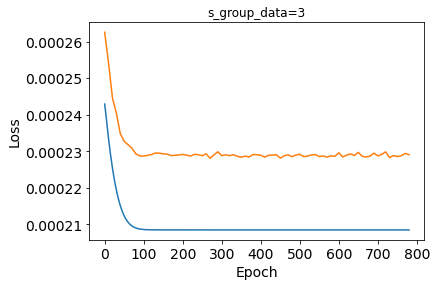

In [11]:
plt.plot(train_losses2)
plt.plot(np.arange(0,len(train_losses2),10),valid_losses2)
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title(f's_group_data={s_group_data}')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [640]:
i=1
kernel_size=9
seed=2050
model = torch.load(f'./models/dynamic/diffusion_dynamic_s_group={i}_k={kernel_size}_{seed}.pth')

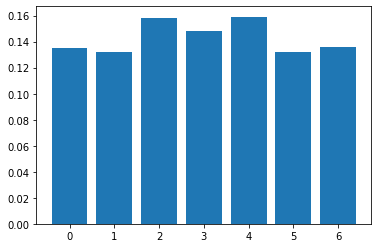

In [12]:
for j,param in enumerate(model.parameters()):
    plt.bar(range(kernel_size),F.softmax(param[0,0,:],dim=-1).detach())

In [13]:
'generate test data'
s_group_data = s_group_data
batch = 1
grid_size = 100*s_group_data
# 'number of particles'
N = 1000
steps = 100*s_group_data*s_group_data
scale=1
grids = np.zeros([batch,steps, grid_size])
for b in tqdm(range(batch)):
    grid = np.zeros([steps,grid_size])
    # initialize the position for first step
    posi = grid_size//2
    position = np.array([int(i) for i in np.ones(N)*posi])#np.array([int(i) for i in np.ones(N)*grid_size // 2])#(grid_size // 2, grid_size // 2)
    grid[0, position] = N

    # avalible direction for each step 
    directions = [-1,1]
    for i in range(steps-1):
        # random choose a direction
        direction = np.random.choice([-scale, scale], N)
        # update the postion of particle
        position = np.array([int(i) for i in (position + direction) % grid_size])
        # move forward
        for x in range(N):
            grid[i+1,position[x]] =grid[i+1,position[x]] + 1
    # normalization
    grids[b,:,:] = grid/N
grids.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


(1, 900, 300)

s_group: 3
1 900 300
(1, 100, 100)
center: [50]


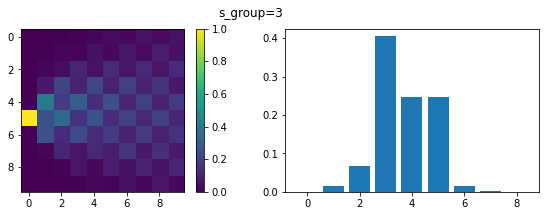

In [15]:
'renormalization by hand, the size of macro matrix is 100*100'
s_group = s_group_data
print('s_group:',s_group)
t_group = s_group*s_group
plt.figure(figsize=(10,3))
plt.subplot(121)
aa = grids[:,:t_group*int(grids.shape[1]//t_group),:s_group*int(grids.shape[2]//s_group)]

b = aa.shape[0]
t = aa.shape[1]
L = aa.shape[2]
print(b,t,L)
aa = aa.reshape(batch,t,-1, s_group)
# sum over the space lattice with s_group
space_macro = aa.sum(axis=-1)
# take the interval of time with t_time
# macro_data is the matrix after renormalizationmacro_data = space_macro[:,::t_group,:]
print(macro_data.shape)
center = np.where(macro_data[:,0,:] == 1)[1]
print('center:',center)
# Take kernel size=9 as an example to extract the kernel distribution of data
center_index = np.where((center<macro_data.shape[-1]-5) & (center>4))[0]
for b in range(macro_data.shape[0]):
    kernels = np.zeros([len(center_index),1,9])
    count = 0
    if center[b] < macro_data.shape[-1]-5 and  center[b] > 4:
        kernels[count] = macro_data[b,1:2,center[b]-4:center[b]+5]
        count += 1
macro_data = torch.tensor(macro_data, dtype=torch.float)
plt.imshow(macro_data[-1,:10,center[-1]-5:center[-1]+5].T)
plt.colorbar()
plt.subplot(122)
plt.bar(range(kernels.shape[-1]),np.mean(kernels,axis=0)[0,:])
plt.suptitle(f's_group={s_group}')
plt.show()

In [17]:
macro_data.shape

torch.Size([1, 100, 100])

In [18]:
test_data_x = macro_data[0,1:,:]
test_data_y = macro_data[0,:-1,:]
test_data_x.shape

torch.Size([99, 100])

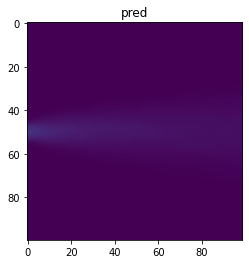

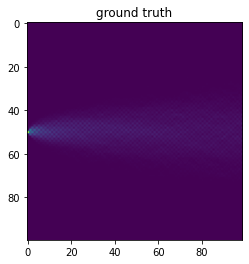

In [19]:
pred = model(test_data_x)
plt.imshow(pred.detach()[:100,:].T,vmin=0,vmax=1)
plt.title('pred')
plt.show()
plt.imshow(test_data_y.detach()[:100,:].T,vmin=0,vmax=1)
plt.title('ground truth')
plt.show()

In [20]:
torch.mean(abs(test_data_y - pred.detach()))

tensor(0.0034)